In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

CHANDRU M 212222230026

In [3]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [4]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [5]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [6]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [9]:
print('Chandru M 212222230026\n')
x_train.shape, y_train.shape, x_test.shape, y_test.shape

Chandru M 212222230026



((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [10]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [11]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [12]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
  def __init__(self, input_size=1,hidden_size=64,num_layers=2,output_size=1):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,output_size)
  def forward(self, x):
    out,_=self.rnn(x)
    out=self.fc(out[:,-1,:])
    return out

In [13]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
!pip install torchinfo

In [15]:
from torchinfo import summary
# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/20], Loss: 0.0972
Epoch [2/20], Loss: 0.0277
Epoch [3/20], Loss: 0.0025
Epoch [4/20], Loss: 0.0010
Epoch [5/20], Loss: 0.0006
Epoch [6/20], Loss: 0.0005
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0005
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0005
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0005
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0004
Epoch [19/20], Loss: 0.0004
Epoch [20/20], Loss: 0.0004


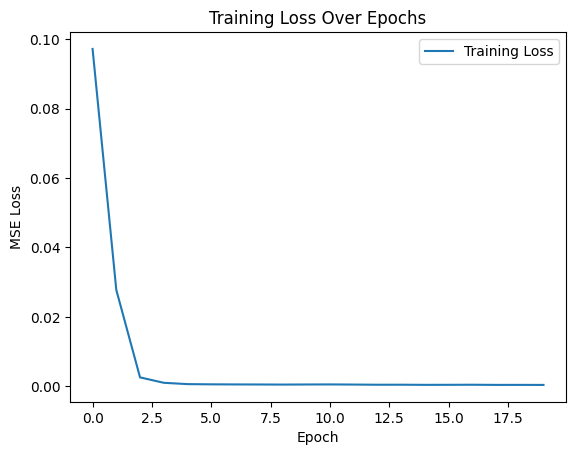

In [17]:
## Step 3: Train the Model

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
  train_losses = []
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
      x_batch,y_batch=x_batch.to(device),y_batch.to(device)
      optimizer.zero_grad()  # Clear previous gradients
      outputs = model(x_batch)  # Forward pass
      loss = criterion(outputs, y_batch)  # Compute loss
      loss.backward()  # Backpropagation
      optimizer.step()  # Update weights
      total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
    # Plot training loss
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title('Training Loss Over Epochs')
  plt.legend()
  plt.show()

train_model(model,train_loader,criterion,optimizer)

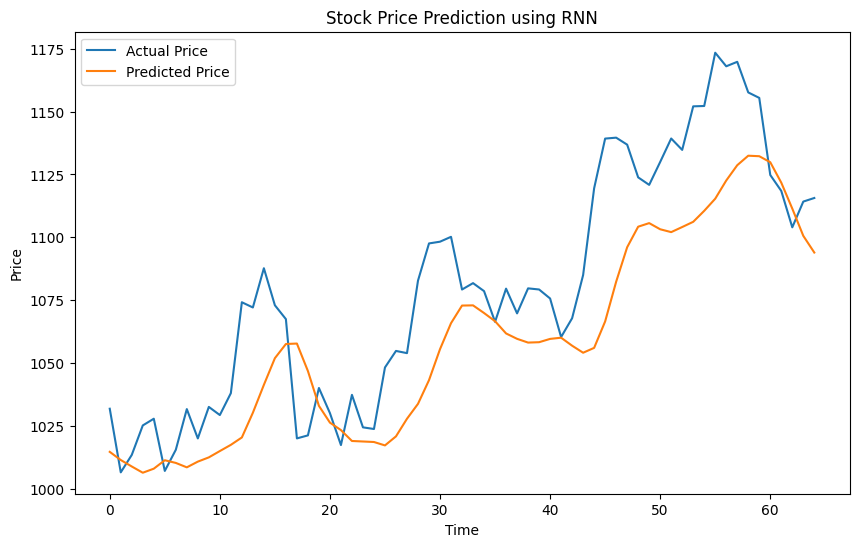

Predicted Price: [1093.9391]
Actual Price: [1115.65]


In [18]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')

Epoch [1/20], Loss: 0.0902
Epoch [2/20], Loss: 0.0225
Epoch [3/20], Loss: 0.0026
Epoch [4/20], Loss: 0.0007
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0004
Epoch [19/20], Loss: 0.0004
Epoch [20/20], Loss: 0.0004


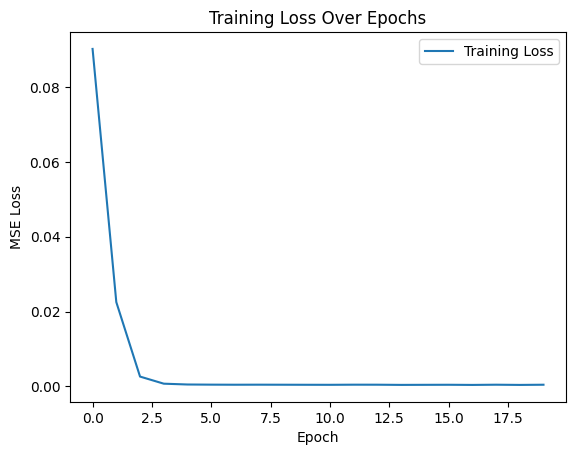

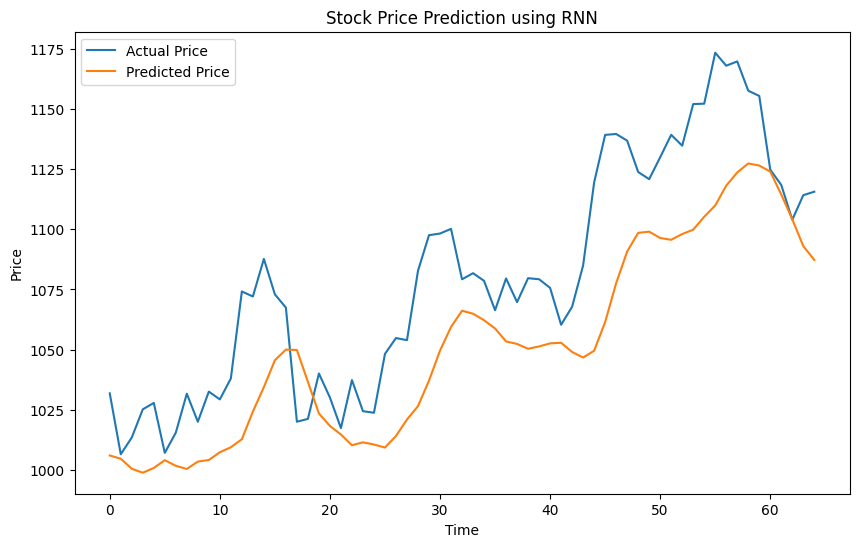

Predicted Price: [1087.2836]
Actual Price: [1115.65]


In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Step 2: Define RNN Model
class RNNModel(nn.Module):
  def __init__(self, input_size=1,hidden_size=64,num_layers=2,output_size=1):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,output_size)
  def forward(self, x):
    out,_=self.rnn(x)
    out=self.fc(out[:,-1,:])
    return out

model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

!pip install torchinfo

from torchinfo import summary
# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Step 3: Train the Model

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
  train_losses = []
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
      x_batch,y_batch=x_batch.to(device),y_batch.to(device)
      optimizer.zero_grad()  # Clear previous gradients
      outputs = model(x_batch)  # Forward pass
      loss = criterion(outputs, y_batch)  # Compute loss
      loss.backward()  # Backpropagation
      optimizer.step()  # Update weights
      total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
    # Plot training loss
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title('Training Loss Over Epochs')
  plt.legend()
  plt.show()

train_model(model,train_loader,criterion,optimizer)

## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')